# Estratégia de Dual Momentum

As estratégias de **momentum** em investimentos consistem na noção que ativos com retornos positivos tendem a continuar se valorizando, enquanto ativos com retornos fracos ou negativos tendem a seguir na mesma trajetória.

No início das pesquisas acadêmicas em finanças, a ideia de "momentum" não era bem aceita, pois prevaleciam noções estabelecidas, como a Hipótese do Mercado Eficiente e a imprevisibilidade dos retornos futuros (*random walk*).

No entanto, no início da década de 70, com o desenvolvimento do conceito de "finanças comportamentais" e o surgimento de **fatores** capazes de explicar os retornos obtidos, como valor e tamanho, as estratégias de momentum ganharam força.

### Objetivo

O objetivo deste estudo é testar uma estratégia chamada "Dual Momentum", que combina dois tipos de momentum: absoluto e relativo. O momentum absoluto compara os retornos entre classes de ativos distintas, como a bolsa brasileira e títulos públicos, escolhendo a classe com maior força relativa. Já o momentum relativo compara dois ativos dentro da mesma classe, como a bolsa brasileira e a bolsa americana, ambos ativos de risco.

O resultado esperado é a construção de um portfólio que gere **alpha** (retorno em excesso) em relação ao índice de referência, ao mesmo tempo que apresenta menor volatilidade. A premissa do dual momentum é possibilitar a participação em momentos de *bull market* e evitar grandes perdas em longos períodos de *bear market*, investindo em ativos defensivos.

### Definição do Problema

Para atingir os objetivos descritos, vamos selecionar os seguintes ativos:

- IBOVESPA (bolsa brasileira)
- S&P500 em BRL (bolsa americana em reais)
- IMA-B 5 (títulos públicos indexados ao IPCA com prazo de até 5 anos)
- CDI (taxa livre de risco)

A estratégia consiste em verificar qual ativo apresentou o maior retorno nos últimos 12 meses, investir nesse ativo e rebalancear o portfolio mensalmente. Para isso, é necessário obter a série temporal do preço de fechamento diário desses ativos e realizar as etapas necessárias de processamento de dados para gerar os sinais e estimar a eficácia da estratégia. Esse processo é conhecido em finanças como **backtest**.

Esse processo em si não representa um problema de machine learning. No entanto, um objetivo futuro é estimar a variância e a volatilidade dos ativos para equilibrar o portfólio e reduzir grandes drawdowns, conhecidos na literatura como "momentum crashes".

In [1]:

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

from utils.prices import historic_imab5, historic_sp500, historic_cdi

STAR_DATE = '2004-01-01'
END_DATE = datetime.today().strftime('%Y-%m-%d')

#### Importando os dados

In [2]:
IBOV = yf.Ticker('^BVSP')
ibov_prices = IBOV.history(start=STAR_DATE, end=END_DATE)['Close']
ibov_prices.index = pd.to_datetime(ibov_prices.index).date

In [3]:
cdi = historic_cdi(start=STAR_DATE, end=END_DATE)
imab5 = historic_imab5(start=STAR_DATE, end=END_DATE)

In [4]:
sp500_prices = historic_sp500(start=STAR_DATE, end=END_DATE, brl=True)

#### Obtendo os dias de negociação dos ativos de risco

Esses dias serão utilizados para normalizar as demais séries temporais, com o objetivo de padronizar a janela de análise e tratar valores faltantes (NAs).

In [5]:
trading_days = ibov_prices.index.to_frame(index=False, name='Date')

trading_days.tail(10)

,Date
5126,2024-09-13
5127,2024-09-16
5128,2024-09-17
5129,2024-09-18
5130,2024-09-19
5131,2024-09-20
5132,2024-09-23
5133,2024-09-24
5134,2024-09-25
5135,2024-09-26


#### Normalizando as séries temporais

In [6]:
cdi_normalized = pd.merge(trading_days, cdi, left_on='Date', right_index=True, how='left').set_index('Date').squeeze()
imab5_normalized = pd.merge(trading_days, imab5, left_on='Date', right_index=True, how='left').set_index('Date').squeeze()

In [7]:
relative_prices = pd.merge(ibov_prices, sp500_prices, left_index=True, right_index=True, how='left').set_axis(['IBOV', 'SP500 BRL'], axis=1)
relative_prices = relative_prices.set_axis(['IBOV', 'SP500 BRL'], axis=1)

In [9]:
print(relative_prices['IBOV'].isna().value_counts())
print("\n")
print(relative_prices['SP500 BRL'].isna().value_counts())

IBOV
False    5136
Name: count, dtype: int64


SP500 BRL
False    5005
True      131
Name: count, dtype: int64


Podemos observar que a série temporal do S&P 500 em reais possui 131 "dias" faltantes. Esse número de NAs não é expressivo e pode ser explicado pela incompatibilidade dos dias de negociação no Brasil e nos EUA, devido a feriados e outras circunstâncias.

Para tratar esses valores faltantes, podemos utilizar o método `ffill()` do Pandas. Esse método preenche os valores NAs com o valor não-nulo anterior mais próximo. Esse tratamento é satisfatório, pois não causará grandes impactos em nossas análises.

In [10]:
relative_prices['SP500 BRL'] = relative_prices['SP500 BRL'].ffill()

print(relative_prices['SP500 BRL'].isna().value_counts())

SP500 BRL
False    5136
Name: count, dtype: int64


#### Tabela principal de preços

In [11]:
ativos = ['CDI', 'IMA-B 5', 'IBOV', 'SP500 BRL']

prices = pd.concat([cdi_normalized, imab5_normalized, relative_prices['IBOV'], relative_prices['SP500 BRL']], keys=ativos, join='inner', axis=1)

prices

,CDI,IMA-B 5,IBOV,SP500 BRL
2004-01-02,1.000000,1.000000,22445.0,3199.294920
2004-01-05,1.000601,1.000576,23532.0,3212.579110
2004-01-06,1.001202,1.001922,23576.0,3203.358561
2004-01-07,1.001803,1.003517,23320.0,3235.157533
2004-01-08,1.002405,1.007081,23717.0,3235.933022
...,...,...,...,...
2024-09-20,8.260848,11.262325,131065.0,31235.716555
2024-09-23,8.264166,11.266000,130568.0,31707.182247
2024-09-24,8.267486,11.297217,132156.0,31360.274648
2024-09-25,8.270807,11.307937,131586.0,31321.361053


É possível notar que alguns ativos não estão normalizados; por isso, é necessário garantir que todas as séries iniciem em 1 para obter uma base de comparação justa. Após normalizar os preços dos ativos, podemos visualizar seus retornos em um gráfico de linhas.

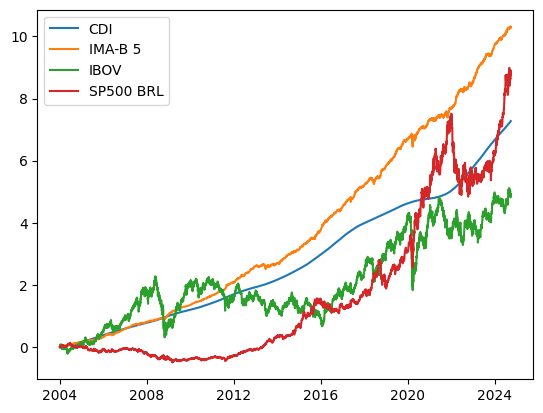

In [13]:
prices = (prices / prices.iloc[0]).dropna()

plt.plot(prices - 1)
plt.legend(prices.columns)
plt.show()

Desde 2004, em pouco mais de 20 anos, o ativo que melhor performou foi o IMA-B 5, um índice de títulos públicos atrelados ao IPCA com duração de até 5 anos. Além da rentabilidade ser a maior no período, o IMA-B 5 também mostrou ser um ativo pouco volátil, representando um excelente equilíbrio entre risco e retorno.

Outro destaque é a performance ruim do índice IBOVESPA, que apresentou uma rentabilidade inferior à taxa livre de risco, o CDI.

### Calculando o momentum dos ativos (12M)

Para calcular o *momentum* dos ativos, etapa fundamental para aplicar a estratégia, podemos seguir duas abordagens: (i) calcular o retorno nos últimos 12 meses normalmente ou (ii) excluir o último mês, calculando apenas o retorno dos 11 primeiros meses em cada janela de 12 meses.

Essa exclusão é realizada porque há evidências na literatura, como em [Jegadeesh e Titman (1993)](https://www.bauer.uh.edu/rsusmel/phd/jegadeesh-titman93.pdf), que mostram que estratégias de momentum que excluem o último mês geralmente superam aquelas que incluem todos os 12 meses. Isso ocorre porque estamos capturando a tendência sustentada dos retornos dos ativos, evitando os impactos negativos das reversões de curto prazo.

A pesquisa científica em finanças comportamentais descobriu que, no curto prazo, os retornos dos ativos podem ser explicados por movimentos de reversão, especialmente dentro do último mês. Portanto, para calcular o retorno dos últimos 12 meses, vamos utilizar a estratégia de não considerar os retornos do último mês.

In [14]:
shifted_prices = prices.shift(21)
momentum_returns = shifted_prices.pct_change(periods=231).dropna()

momentum_returns

,CDI,IMA-B 5,IBOV,SP500 BRL
2005-01-06,0.147682,0.160735,0.142036,0.011415
2005-01-07,0.147718,0.161035,0.061916,0.001062
2005-01-10,0.147753,0.160045,0.059043,0.021467
2005-01-11,0.147788,0.159137,0.051715,0.019866
2005-01-12,0.147824,0.155855,0.051271,0.023074
...,...,...,...,...
2024-09-20,0.102865,0.076677,0.147031,0.432860
2024-09-23,0.102758,0.078501,0.142491,0.458825
2024-09-24,0.102670,0.079654,0.178604,0.447177
2024-09-25,0.102581,0.079346,0.179012,0.456991


Em seguida, vamos identificar o retorno dos últimos 12 meses na data do primeiro dia de negociação de cada mês. Dessa forma, podemos realizar o rebalanceamento mensal da estratégia, considerando o *momentum* dos ativos.

In [15]:
time_series = pd.to_datetime(momentum_returns.index).to_series()
first_trading_day = time_series.groupby(time_series.index.to_period('M')).apply(lambda x: x == x.min())

momentum_returns.loc[first_trading_day.values]

,CDI,IMA-B 5,IBOV,SP500 BRL
2005-01-06,0.147682,0.160735,0.142036,0.011415
2005-02-01,0.149233,0.144729,0.081318,-0.015058
2005-03-01,0.151854,0.145800,0.126213,-0.084480
2005-04-01,0.153784,0.125474,0.342857,-0.019450
2005-05-02,0.156111,0.124055,0.247937,-0.046931
...,...,...,...,...
2024-05-02,0.114742,0.085056,0.239266,0.267039
2024-06-03,0.112259,0.079970,0.152167,0.229911
2024-07-01,0.109741,0.080151,0.038929,0.318906
2024-08-01,0.106807,0.072969,0.045554,0.428546


In [16]:
conditions = [
    first_trading_day.values & (momentum_returns['IBOV'] > momentum_returns['CDI']) & (momentum_returns['IBOV'] > momentum_returns['SP500 BRL']),
    first_trading_day.values & (momentum_returns['IBOV'] > momentum_returns['CDI']) & (momentum_returns['IBOV'] <= momentum_returns['SP500 BRL']),
    first_trading_day.values & (momentum_returns['IBOV'] <= momentum_returns['CDI']),
]

cases = ['IBOV', 'SP500 BRL', 'IMA-B 5']

momentum_returns['Investment'] = np.select(conditions, cases, default=None)
momentum_returns['Investment'] = momentum_returns['Investment'].ffill()

momentum_returns

,CDI,IMA-B 5,IBOV,SP500 BRL,Investment
2005-01-06,0.147682,0.160735,0.142036,0.011415,IMA-B 5
2005-01-07,0.147718,0.161035,0.061916,0.001062,IMA-B 5
2005-01-10,0.147753,0.160045,0.059043,0.021467,IMA-B 5
2005-01-11,0.147788,0.159137,0.051715,0.019866,IMA-B 5
2005-01-12,0.147824,0.155855,0.051271,0.023074,IMA-B 5
...,...,...,...,...,...
2024-09-20,0.102865,0.076677,0.147031,0.432860,IMA-B 5
2024-09-23,0.102758,0.078501,0.142491,0.458825,IMA-B 5
2024-09-24,0.102670,0.079654,0.178604,0.447177,IMA-B 5
2024-09-25,0.102581,0.079346,0.179012,0.456991,IMA-B 5


O código acima implementa a lógica da estratégia de selecionar o ativo com maior força relativa nos últimos 12 meses, considerando as respectivas classes de ativos: ativos de risco e títulos públicos.

Analisando os dados obtidos, podemos fazer uma simples contagem de cada categoria na coluna 'Investment' e calcular a proporção de dias investidos em cada ativo.

In [17]:
momentum_returns['Investment'].value_counts(normalize=True).round(2)

Investment
IMA-B 5      0.53
IBOV         0.36
SP500 BRL    0.11
Name: proportion, dtype: float64

Seguindo a estratégia descrita, nosso portfólio ficou aproximadamente 50% dos dias investido em IMA-B 5, 35% em IBOV e apenas 10% em S&P 500.

### Calculando o retorno da estratégia

In [18]:
dual_momentum = prices.pct_change().join(momentum_returns[['Investment']], how='right')

dual_momentum['Dual Momentum'] = dual_momentum.apply(lambda row: row[row['Investment']], axis=1)
dual_momentum = dual_momentum.drop(columns=['Investment'])

dual_momentum

,CDI,IMA-B 5,IBOV,SP500 BRL,Dual Momentum
2005-01-06,0.000648,0.000196,-0.013162,0.007617,0.000196
2005-01-07,0.000648,0.000042,0.015595,-0.007854,0.000042
2005-01-10,0.000648,0.000424,-0.018386,0.001233,0.000424
2005-01-11,0.000648,0.000588,0.003211,-0.001199,0.000588
2005-01-12,0.000648,0.000511,0.005745,0.004241,0.000511
...,...,...,...,...,...
2024-09-20,0.000402,-0.001844,-0.015459,0.008852,-0.001844
2024-09-23,0.000402,0.000326,-0.003792,0.015094,0.000326
2024-09-24,0.000402,0.002771,0.012162,-0.010941,0.002771
2024-09-25,0.000402,0.000949,-0.004313,-0.001241,0.000949


In [19]:
dual_momentum_eval = (1 + dual_momentum).cumprod()
dual_momentum_eval = (dual_momentum_eval / dual_momentum_eval.iloc[0]) - 1

dual_momentum_eval

,CDI,IMA-B 5,IBOV,SP500 BRL,Dual Momentum
2005-01-06,0.000000,0.000000,0.000000,0.000000,0.000000
2005-01-07,0.000648,0.000042,0.015595,-0.007854,0.000042
2005-01-10,0.001297,0.000466,-0.003078,-0.006631,0.000466
2005-01-11,0.001946,0.001055,0.000123,-0.007822,0.001055
2005-01-12,0.002596,0.001567,0.005869,-0.003614,0.001567
...,...,...,...,...,...
2024-09-20,6.092193,8.566115,4.378791,8.664838,14.212341
2024-09-23,6.095042,8.569236,4.358395,8.810717,14.217305
2024-09-24,6.097892,8.595752,4.423565,8.703378,14.259472
2024-09-25,6.100743,8.604857,4.400172,8.691338,14.273951


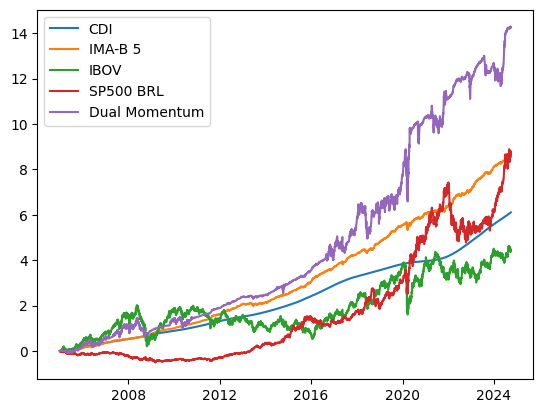

In [20]:
plt.plot(dual_momentum_eval)
plt.legend(dual_momentum_eval.columns)
plt.show()

Uma forma eficiente de confirmar a eficácia da estratégia, além de verificar se ela superou os ativos individualmente, é criando um benchmark. Para o benchmark, podemos criar um portfólio ingênuo (naive), que investe nos três ativos da estratégia com pesos iguais.

Ou seja, sem qualquer esforço, qualquer investidor poderia montar uma carteira com pesos iguais. A premissa de qualquer estratégia mais sofisticada é superar esse portfólio naive.

### Criando um portfolio para benchmark da estratégia

In [21]:
naive_portfolio = dual_momentum_eval[['IBOV', 'SP500 BRL', 'IMA-B 5']].mean(axis=1).rename('Naive Portfolio')
naive_portfolio.index = pd.to_datetime(naive_portfolio.index).date

naive_portfolio

2005-01-06    0.000000
2005-01-07    0.002594
2005-01-10   -0.003081
2005-01-11   -0.002215
2005-01-12    0.001274
                ...   
2024-09-20    7.203248
2024-09-23    7.246116
2024-09-24    7.240898
2024-09-25    7.232122
2024-09-26    7.243547
Name: Naive Portfolio, Length: 4884, dtype: float64

#### Avaliação da estratégia

In [22]:
benchmark = pd.concat(
    [dual_momentum_eval['CDI'], naive_portfolio, dual_momentum_eval['Dual Momentum']],
    keys=['CDI', 'Naive Portfolio', 'Dual Momentum'], 
    join='inner', 
    axis=1
)

benchmark

,CDI,Naive Portfolio,Dual Momentum
2005-01-06,0.000000,0.000000,0.000000
2005-01-07,0.000648,0.002594,0.000042
2005-01-10,0.001297,-0.003081,0.000466
2005-01-11,0.001946,-0.002215,0.001055
2005-01-12,0.002596,0.001274,0.001567
...,...,...,...
2024-09-20,6.092193,7.203248,14.212341
2024-09-23,6.095042,7.246116,14.217305
2024-09-24,6.097892,7.240898,14.259472
2024-09-25,6.100743,7.232122,14.273951


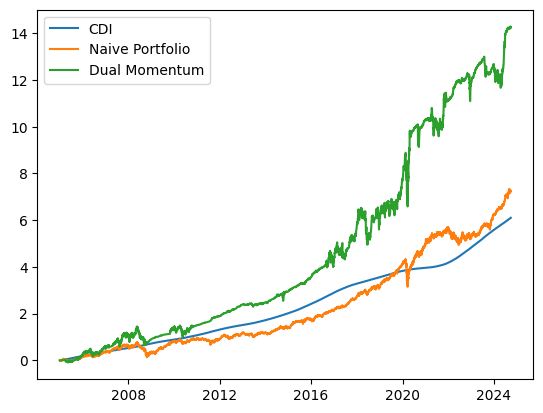

In [23]:
plt.plot(benchmark)
plt.legend(benchmark.columns)
plt.show()

In [24]:
benchmark = benchmark + 1

series_start = benchmark.index.min()
series_end = benchmark.index.max()

years = (series_end - series_start).days / 365

benchmark_cagr = (benchmark.iloc[-1] / (benchmark.iloc[0])) ** (1 / years) - 1
benchmark_vol = benchmark.pct_change().std() * (252 ** 0.5)

In [25]:
results = pd.concat([benchmark_cagr, benchmark_vol], keys=['CAGR', 'Volatility'], axis=1)
results['Sharpe Ratio'] = (results['CAGR'] - 0.10) / results['Volatility']

results

,CAGR,Volatility,Sharpe Ratio
CDI,0.104453,0.002379,1.872143
Naive Portfolio,0.112814,0.123794,0.103510
Dual Momentum,0.148105,0.168326,0.285785


Observando as métricas de risco (volatilidade) e retorno (CAGR) utilizadas, podemos perceber que a estratégia superou o portfólio de pesos iguais, apresentando um retorno superior de 14.8% ao ano, embora com uma volatilidade também maior.

No entanto, apesar da volatilidade ser maior, o Sharpe Ratio, que mede o retorno obtido para cada unidade de risco assumida, foi superior, indicando uma melhor relação entre risco e retorno.

Nesta análise, mantive o CDI como comparação por ser a taxa livre de risco; no entanto, a carteira de Dual Momentum se comportou muito mais como um ativo de risco do que como um ativo defensivo, devido à sua volatilidade. Portanto, vamos analisar essa carteira em comparação com outros ativos de risco (S&P 500 e IBOV).

In [26]:
ativos_risco = pd.concat(
    [dual_momentum_eval['IBOV'], dual_momentum_eval['SP500 BRL'], dual_momentum_eval['Dual Momentum']],
    keys=['IBOV', 'SP500 BRL', 'Dual Momentum'], 
    join='inner', 
    axis=1
)

In [27]:
ativos_risco = ativos_risco + 1

series_start = ativos_risco.index.min()
series_end = ativos_risco.index.max()

years = (series_end - series_start).days / 365

ativos_risco_cagr = (ativos_risco.iloc[-1] / (ativos_risco.iloc[0])) ** (1 / years) - 1
ativos_risco_vol = ativos_risco.pct_change().std() * (252 ** 0.5)

In [28]:
results_ativos_risco = pd.concat([ativos_risco_cagr, ativos_risco_vol], keys=['CAGR', 'Volatility'], axis=1)
results_ativos_risco['Sharpe Ratio'] = (results_ativos_risco['CAGR'] - 0.10) / results_ativos_risco['Volatility']

results_ativos_risco

,CAGR,Volatility,Sharpe Ratio
IBOV,0.089809,0.265978,-0.038315
SP500 BRL,0.121867,0.209103,0.104576
Dual Momentum,0.148105,0.168326,0.285785


Apesar de a estratégia de Dual Momentum ser volátil, em comparação com outros ativos de risco, ela apresentou menor volatilidade e melhor retorno que os demais ativos comparados.

Essa volatilidade da estratégia é caracterizado por um fenômeno conhecido como "Momentum Crash", que corresponde a correções abruptas e severas em ativos que estavam performando muito bem. Um exemplo notável pode ser observado no ano de 2020, quando, devido à pandemia de COVID-19, os mercados ao redor do mundo sofreram grandes quedas nos ativos de risco.

Esses eventos são amplamente estudados na literatura, que busca desenvolver formas de mitigar esses efeitos, o que pode ser tema de um próximo trabalho que explore técnicas de machine learning aplicadas a séries temporais.

#### Calculando drawdowns

Outro estudo interessante é avaliar o drawdown, que corresponde às variações negativas dos ativos. Entender o risco da estratégia também está relacionado ao entendimento desses drawdowns e à duração de cada um deles.

In [29]:
cum_returns = (1 + dual_momentum[['IBOV', 'SP500 BRL', 'Dual Momentum']]).cumprod()
cum_max = cum_returns.cummax()

drawdown = (cum_returns - cum_max) / cum_max

drawdown

,IBOV,SP500 BRL,Dual Momentum
2005-01-06,0.000000,0.000000,0.000000
2005-01-07,0.000000,-0.007854,0.000000
2005-01-10,-0.018386,-0.006631,0.000000
2005-01-11,-0.015234,-0.007822,0.000000
2005-01-12,-0.009577,-0.003614,0.000000
...,...,...,...
2024-09-20,-0.045717,-0.022310,-0.005119
2024-09-23,-0.049336,-0.007553,-0.004794
2024-09-24,-0.037774,-0.018411,-0.002036
2024-09-25,-0.041924,-0.019629,-0.001090


In [30]:
for col in drawdown.columns:
    print(f"{col} {round(min(drawdown[col]), 2) * 100}%")

IBOV -60.0%
SP500 BRL -52.0%
Dual Momentum -33.0%


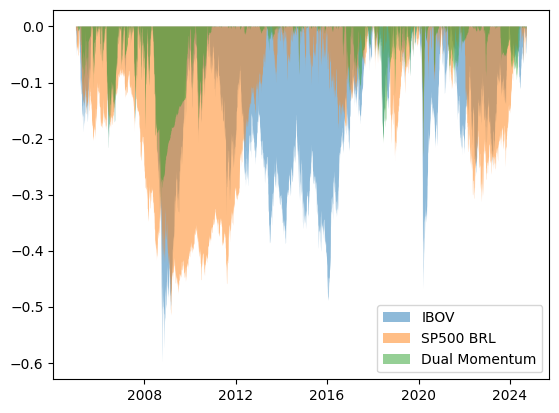

In [31]:
for col in drawdown.columns:
    plt.fill_between(x=drawdown.index, y1=drawdown[col], alpha=0.5, label=col)

plt.legend()
plt.show()

In [32]:
for col in drawdown.columns:    
    drawdown_shifts = (drawdown[col] < 0).ne((drawdown[col] < 0).shift()).cumsum()
    drawdown_durations = (drawdown[col] < 0).groupby(drawdown_shifts).size()

    print('\n')
    print(col)
    print(f"Duração média: {round(drawdown_durations.mean())} dias")
    print(f"Duração máxima: {drawdown_durations.max()} dias (apróx. {round(drawdown_durations.max() / 365, 1)} anos)")



IBOV
Duração média: 23 dias
Duração máxima: 2304 dias (apróx. 6.3 anos)


SP500 BRL
Duração média: 20 dias
Duração máxima: 2017 dias (apróx. 5.5 anos)


Dual Momentum
Duração média: 8 dias
Duração máxima: 403 dias (apróx. 1.1 anos)


Analisando os drawdowns, observamos que, mesmo com o problema dos **momentum crashes**, a estratégia apresentou drawdowns menores (menos profundos) e de menor duração, em comparação aos demais ativos de risco.

A duração máxima do drawdown é extremamente importante, pois, no caso do IBOV, um investidor que teve o azar de investir nesse ativo em um determinado dia ao longo desses anos ficou mais de seis anos vendo seu investimento "negativo" e só conseguiu recuperar o valor investido após esse período. Isso sem contar o custo de oportunidade, já que, durante esse período, ele poderia ter investido no CDI, sem nenhum risco. Ou seja, esse investidor teve um prejuízo enorme.

## Conclusões Finais

A estratégia de Dual Momentum se mostrou bastante eficiente, conforme os objetivos do estudo, pois apresentou um excelente retorno (14% a.a) nos últimos 20 anos, com uma volatilidade menor do que outros ativos de risco, como o S&P500 e o IBOV. Apesar do excelente retorno, a estratégia tem alguns "problemas":

1. É uma estratégia simples, mas que exige muita disciplina do investidor, principalmente em momentos de grande volatilidade. Apesar de evitar que o investidor participe de longos bear markets, há o risco de *tracking error*, ou seja, em períodos curtos de tempo, a estratégia pode apresentar desempenho inferior aos ativos de risco.

2. Como observamos no backtest, a estratégia sofre de um problema conhecido como *momentum crashes*, o que a torna bastante volátil em certos períodos, podendo causar prejuízos se o investidor não tiver disciplina e não se mantiver fiel à estratégia.

Esses problemas são comuns a outras estratégias de momentum. No entanto, um destaque positivo da estratégia estudada, em comparação com outras, é que ela pode ser facilmente replicada por qualquer investidor e possui baixos custos de transação, já que envolve poucos ativos e transações pouco frequentes.

No Brasil, o investidor pode replicar essa estratégia utilizando ETFs (Exchange Traded Funds), que são fundos negociados em bolsa que replicam índices ou ativos específicos, proporcionando uma forma prática de diversificação e liquidez. Seguem as opções de investimento em ETFs para cada ativo utilizado na estratégia:

- BOVA11 (IBOV)
- IVVB11 (S&P 500)
- B5P211 (IMA-B 5)